# Поиск изображения по описанию


**Цель проекта:** разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

#Описание данных

В файле train_dataset.csv собрана информация, необходимая для обучения:
- имя файла изображения,
- идентификатор описания,
- текст описания.
Для одной картинки может быть доступно до 5 описаний.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- Доля людей, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение.
Для одной картинки может быть доступно до 5 описаний.

В папке test_images содержатся изображения для тестирования модели.

# Загрузка данных

In [1]:
# Загрузим библиотеку Hugging Face
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00


In [2]:
# Подключенм требуемые библиотеки
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import transformers
import matplotlib.image as mpimg
import torch
import os
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from torch import nn

In [3]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

DATA_PATH = '/content/to_upload'

## Загрузка тренировочных данных

In [4]:
# Загрузим тренировочный датасет
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))

In [5]:
# Посмотрим на первые строки данных
df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [6]:
# Посмотрим общую информацию о данных
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [7]:
# Посмотрим Количество уникальных значений
df_train.nunique()

image         1000
query_id       977
query_text     977
dtype: int64

Количество картинок - 1000, но описания есть только к 977.

In [8]:
# Загрузим тренировочные данные по соответствию изображения и описания, полученные с помощью краудсорсинга
crowd_annotations = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'proportion_conf', 'conf', 'not_comf'])

In [9]:
crowd_annotations.head()

image                     query_id  proportion_conf  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

   conf  not_comf  
0     3         0  
1     0         3  
2     0         3  
3     0         3  
4     0         3

In [10]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   query_id         47830 non-null  object 
 2   proportion_conf  47830 non-null  float64
 3   conf             47830 non-null  int64  
 4   not_comf         47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [11]:
crowd_annotations.nunique()

image              1000
query_id           1000
proportion_conf      12
conf                  6
not_comf              7
dtype: int64

In [12]:
# Загрузим тренировочные данные по соответствию изображения и описания, полученные в результате опроса экспертов.
expert_annotations = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])

In [13]:
expert_annotations.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

In [14]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [15]:
expert_annotations.nunique()

image       1000
query_id     977
expert_1       4
expert_2       4
expert_3       4
dtype: int64

## Загрузка тестовых данных

In [16]:
# Загрузим тренировочный датасет
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), sep ='|', usecols=[1, 2, 3])

In [17]:
# Посмотрим, что он из себя представяет
df_test.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


Нам предоставлен следующие данные:
- датасет с 5822 строками с именами файлов изображений с их описаниями, в которых 1000 уникальных изображений и 977 уникальных описаний;
- наборы тренировочных и тестовых изображений;
- датасет с 47830 строками с отзывами людей о соответствии изображений и описаний;
датасет с 5822 строками с мнениями экспертов о соответствии изображения и описания

# Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов.   Для решения задачи необходимо эти оценки агрегировать — превратить в одну.
Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:
Доля исполнителей, подтвердивших, что текст соответствует картинке.
Количество исполнителей, подтвердивших, что текст соответствует картинке.
Количество исполнителей, подтвердивших, что текст не соответствует картинке.

После анализа экспертных и краудсорсинговых оценок объединим их в одну по критерию: оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

## Исследование экспертных оценок

In [19]:
expert_annotations.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

In [20]:
# создадим функцию для выбора мнения большинства
def compare(df):
    if df['expert_1'] == df['expert_2'] or df['expert_1'] == df['expert_3']:
        general = df['expert_1']
    elif df['expert_2'] == df['expert_3']:
        general = df['expert_2']
    else:
        general = 0
    return general

In [21]:
expert_annotations['experts_sum'] = expert_annotations.apply(compare, axis=1)

In [22]:
expert_annotations.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  experts_sum  
0         1            1  
1         2            1  
2         2            1  
3         2            2  
4         2            1

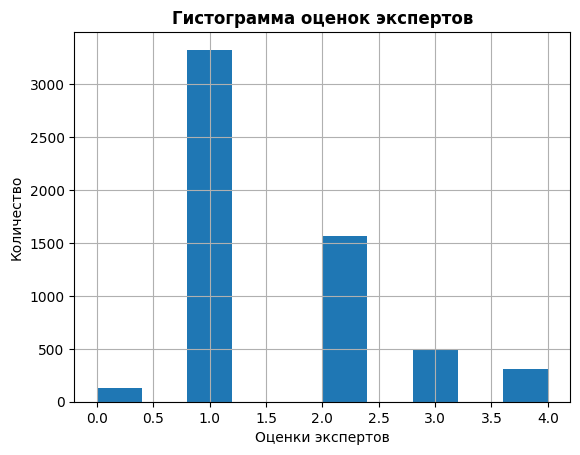

In [23]:
plt.hist(expert_annotations['experts_sum'])
plt.xlabel('Оценки экспертов')
plt.ylabel('Количество')
plt.title('Гистограмма оценок экспертов', fontweight = "bold")
plt.grid(True)
plt.show()

В 126 строках эксперты разошлись во мнениях, поэтому избавимся от этих строк.
Удалим столбцы с мнениями экспертов

In [24]:
expert_annotations = expert_annotations.drop(['expert_1', 'expert_2', 'expert_3'], axis=1)

In [25]:
expert_annotations['experts_sum'] = expert_annotations['experts_sum'].astype(int)

In [26]:
expert_annotations = expert_annotations.loc[expert_annotations['experts_sum'] != 0]

In [27]:
expert_annotations.head()

image                     query_id  experts_sum
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2            1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2            1
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2            1
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2            2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2            1

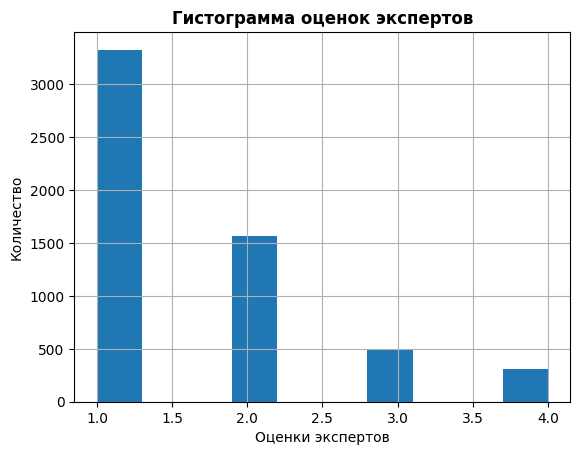

In [28]:
plt.hist(expert_annotations['experts_sum'])
plt.xlabel('Оценки экспертов')
plt.ylabel('Количество')
plt.title('Гистограмма оценок экспертов', fontweight = "bold")
plt.grid(True)
plt.show()

## Объединим таблицы с экспертными оценками о оценками людей

In [29]:
data_summary = pd.merge(crowd_annotations, expert_annotations, how='outer', on=['image', 'query_id'])

In [30]:
data_summary.head()

image                     query_id  proportion_conf  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

   conf  not_comf  experts_sum  
0   3.0       0.0          NaN  
1   0.0       3.0          NaN  
2   0.0       3.0          NaN  
3   0.0       3.0          NaN  
4   0.0       3.0          NaN

In [31]:
data_summary.shape

(51268, 6)

In [32]:
data_summary = data_summary.drop(['conf', 'not_comf'], axis=1)

In [33]:
data_summary.value_counts('experts_sum')

experts_sum
1.0    3327
2.0    1566
3.0     492
4.0     311
dtype: int64

Перемасштабируем оценки экспертов:
- 1 в 0 (изображение и запрос совершенно не соответствуют друг другу)
- 2 в 0.33 (запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует)
- 3 в 0.66 (запрос и текст соответствуют с точностью до некоторых деталей)
- 4 в 1 (запрос и текст соответствуют полностью)

In [34]:
def rescale(df):
  if df['experts_sum'] == 0:
    rescaled = np.NaN
  else:
    rescaled = ((df['experts_sum'] -1) / 3)

  return rescaled

In [35]:
data_summary['experts_rescaled'] = data_summary.apply(rescale, axis=1)

In [36]:
data_summary.value_counts('experts_rescaled')

experts_rescaled
0.000000    3327
0.333333    1566
0.666667     492
1.000000     311
dtype: int64

In [37]:
data_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51268 entries, 0 to 51267
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             51268 non-null  object 
 1   query_id          51268 non-null  object 
 2   proportion_conf   47830 non-null  float64
 3   experts_sum       5696 non-null   float64
 4   experts_rescaled  5696 non-null   float64
dtypes: float64(3), object(2)
memory usage: 2.3+ MB


In [38]:
data_summary = data_summary.drop('experts_sum', axis=1)

Посчитаем суммарную оценку позователей и экспертов (коэффициент для оценки пользователей возьмем 0.4, а для оценки экспертов 0.6)

In [39]:
# Создадим функцию для заполнения
def summerizer(df):
    if math.isnan(df['experts_rescaled']):
        df['exit_mark'] = df['proportion_conf']
    elif math.isnan(df['proportion_conf']):
        df['exit_mark'] = df['experts_rescaled']
    else:
        df['exit_mark'] = df['proportion_conf'] * 0.4 + df['experts_rescaled'] * 0.6
    return df['exit_mark']

In [40]:
data_summary['exit_mark'] = data_summary.apply(summerizer, axis=1)

In [41]:
data_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51268 entries, 0 to 51267
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             51268 non-null  object 
 1   query_id          51268 non-null  object 
 2   proportion_conf   47830 non-null  float64
 3   experts_rescaled  5696 non-null   float64
 4   exit_mark         51268 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.3+ MB


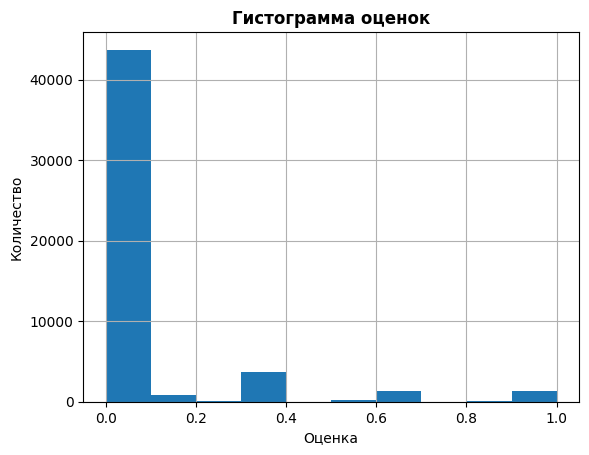

In [42]:
plt.hist(data_summary['exit_mark'])
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.title('Гистограмма оценок', fontweight = "bold")
plt.grid(True)
plt.show()

In [43]:
data_summary = data_summary.drop(['proportion_conf', 'experts_rescaled'], axis=1)

In [44]:
data_summary.head()

image                     query_id  exit_mark
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0

In [45]:
data_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51268 entries, 0 to 51267
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      51268 non-null  object 
 1   query_id   51268 non-null  object 
 2   exit_mark  51268 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [46]:
# создадим датасет из уникальных описаний
df_train_unique = df_train.drop_duplicates('query_id')
df_train_unique

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
12    1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
22    1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
27    1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
31    1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
12    A girl wearing a yellow shirt and sunglasses s...  
22      A man sleeps under a blanket on a city street .  
27    A woman plays with long red ribbons in an empt...  
31           Chinese market street in the winter time .  
...                                                 ...  
5817         A man in an ampitheater talking to a boy .  
5818          a old man walks down the uncrowded road .  
5819       A dog stands on the side of a grassy cliff .  
5820                       A blurry photo of two dogs .  
5821                        A man rows his boat below .  

[977 rows x 3 columns]

In [47]:
# обучим датасеты с оценками и описаниями
df_train_with_marks = data_summary.merge(df_train_unique, on='query_id', how='left')
df_train_with_marks = df_train_with_marks.drop('image_y', axis=1)
df_train_with_marks = df_train_with_marks.rename(columns={'image_x':'image'})
df_train_with_marks

image                     query_id  exit_mark  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   
...                          ...                          ...        ...   
51263   997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2        0.0   
51264   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2        0.0   
51265   997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2        0.0   
51266   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2        0.0   
51267   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2        0.0   

                                              query_text  
0      A woman is signaling is to traffic , as seen f...  
1              A boy in glasses is wearing a red shirt .  
2       A young boy holds onto a blue handle on a pier .  
3      A woman wearing black clothes , a purple scarf...  
4      An older woman with blond hair rides a bicycle...  
...                                                  ...  
51263  A man pulls on his sweater as a kayak lays at ...  
51264  a motorcyclist wearing a red and white jacket ...  
51265                              Two greyhounds race .  
51266  People trackside at a subway station by a train .  
51267         A white birds lands swiftly in the water .  

[51268 rows x 4 columns]

In [48]:
df_train_with_marks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51268 entries, 0 to 51267
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51268 non-null  object 
 1   query_id    51268 non-null  object 
 2   exit_mark   51268 non-null  float64
 3   query_text  50159 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [49]:
# удалим пропуски
df_train_with_marks = df_train_with_marks.dropna()
df_train_with_marks.reset_index(inplace=True)

In [50]:
df_train_with_marks

index                      image                     query_id  \
0          0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1          1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2          2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
3          3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
4          4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   
...      ...                        ...                          ...   
50154  51263   997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2   
50155  51264   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2   
50156  51265   997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2   
50157  51266   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2   
50158  51267   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2   

       exit_mark                                         query_text  
0            1.0  A woman is signaling is to traffic , as seen f...  
1            0.0          A boy in glasses is wearing a red shirt .  
2            0.0   A young boy holds onto a blue handle on a pier .  
3            0.0  A woman wearing black clothes , a purple scarf...  
4            0.0  An older woman with blond hair rides a bicycle...  
...          ...                                                ...  
50154        0.0  A man pulls on his sweater as a kayak lays at ...  
50155        0.0  a motorcyclist wearing a red and white jacket ...  
50156        0.0                              Two greyhounds race .  
50157        0.0  People trackside at a subway station by a train .  
50158        0.0         A white birds lands swiftly in the water .  

[50159 rows x 5 columns]

# Создадим список слов которые могут попадать под юридические ограничения.





In [51]:
# Список слов, по которым будем ограничивать
block_words = ['child', 'toddler', 'teen', 'baby', 'school', 'boy', 'girl', 'kid']

In [52]:
df_train_with_marks.head()

index                      image                     query_id  exit_mark  \
0      0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1      1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2      2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3      3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4      4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

                                          query_text  
0  A woman is signaling is to traffic , as seen f...  
1          A boy in glasses is wearing a red shirt .  
2   A young boy holds onto a blue handle on a pier .  
3  A woman wearing black clothes , a purple scarf...  
4  An older woman with blond hair rides a bicycle...

In [53]:
df_train_with_marks.shape

(50159, 5)

In [54]:
# Получим список записей, которые содержат упоминание детей
block_list_index = []
for word in block_words:
  block_text = df_train_with_marks.query_text.str.contains(word, case=False)
  block_list_index += df_train_with_marks[block_text].index.tolist()
block_list = df_train_with_marks.iloc[block_list_index].query_id.apply(lambda x: x.split('#')[0]).unique()

In [55]:
len(block_list_index)

15280

In [56]:
len(block_list)

293

Исключим из обучающего датасета пары, которые, исходя из подготовленного списка слов, могут попадать под юридические ограничения.

In [57]:
df_train_with_marks_filtered = df_train_with_marks.loc[df_train_with_marks.image.isin(block_list) == False]
df_train_with_marks_filtered.reset_index(inplace=True)

In [58]:
df_train_with_marks_filtered.info()
display(df_train_with_marks_filtered.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35671 entries, 0 to 35670
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   level_0     35671 non-null  int64  
 1   index       35671 non-null  int64  
 2   image       35671 non-null  object 
 3   query_id    35671 non-null  object 
 4   exit_mark   35671 non-null  float64
 5   query_text  35671 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.6+ MB


level_0  index                      image                     query_id  \
0        0      0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1        1      1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2        2      2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
3        3      3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
4        4      4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   

   exit_mark                                         query_text  
0        1.0  A woman is signaling is to traffic , as seen f...  
1        0.0          A boy in glasses is wearing a red shirt .  
2        0.0   A young boy holds onto a blue handle on a pier .  
3        0.0  A woman wearing black clothes , a purple scarf...  
4        0.0  An older woman with blond hair rides a bicycle...

# Подготовим данные к обучению модели.

## Сделаем векторизацию изображений с использованием модели ResNet50 из библиотеки Keras

In [59]:
df_train_images = pd.DataFrame(df_train_with_marks_filtered.image.unique(), columns=['image'])
df_train_images

image
0    1056338697_4f7d7ce270.jpg
1    1082379191_ec1e53f996.jpg
2    1084040636_97d9633581.jpg
3    1107246521_d16a476380.jpg
4    1119015538_e8e796281e.jpg
..                         ...
702   909808296_23c427022d.jpg
703   925491651_57df3a5b36.jpg
704   929679367_ff8c7df2ee.jpg
705    96420612_feb18fc6c6.jpg
706   997722733_0cb5439472.jpg

[707 rows x 1 columns]

In [60]:
datagen_train = ImageDataGenerator(rescale=1.0/255)

train_datagen_flow = datagen_train.flow_from_dataframe(
    dataframe = df_train_images,
    directory = os.path.join(DATA_PATH, 'train_images'),
    x_col='image',
    target_size=(224, 224),
    class_mode=None,
    batch_size=24,
    shuffle=True,
    seed=1
)

Found 707 validated image filenames.


In [61]:
# используем модель ResNet50 предобученную на ImageNet
backbone = ResNet50(weights='imagenet',
                    include_top=False)
# замораживаем ResNet50 без верхушки
backbone.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [62]:
%%time
model_image = Sequential()
model_image.add(backbone)
model_image.add(GlobalAveragePooling2D())

image_features = model_image.predict(train_datagen_flow)

30/30 [==============================] - 17s 194ms/step
CPU times: user 10.9 s, sys: 942 ms, total: 11.8 s
Wall time: 18.8 s


In [63]:
# посмотрим на длину выходного вектора
len(image_features[0])

2048

In [64]:
# объединим датасет изображений и векторы этих изображений
df_train_images = pd.concat([df_train_images, pd.DataFrame(image_features)], axis=1)

In [65]:
df_train_images.head()

image    0    1         2         3         4    5  \
0  1056338697_4f7d7ce270.jpg  0.0  0.0  0.018639  0.011048  0.958586  0.0   
1  1082379191_ec1e53f996.jpg  0.0  0.0  0.000000  0.000000  0.968613  0.0   
2  1084040636_97d9633581.jpg  0.0  0.0  0.000383  0.000000  1.053581  0.0   
3  1107246521_d16a476380.jpg  0.0  0.0  0.000690  0.000000  1.243773  0.0   
4  1119015538_e8e796281e.jpg  0.0  0.0  0.000000  0.000000  1.112910  0.0   

     6         7         8  ...  2038  2039  2040  2041      2042  2043  2044  \
0  0.0  0.937242  0.001327  ...   0.0   0.0   0.0   0.0  0.023551   0.0   0.0   
1  0.0  0.572603  0.020752  ...   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   
2  0.0  0.414605  0.038003  ...   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   
3  0.0  0.882441  0.027580  ...   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   
4  0.0  0.934213  0.015559  ...   0.0   0.0   0.0   0.0  0.030503   0.0   0.0   

       2045  2046  2047  
0  2.196177   0.0   0.0  
1  2.474201   0.0   0.0  
2  2.394659   0.0   0.0  
3  2.361583   0.0   0.0  
4  2.147685   0.0   0.0  

[5 rows x 2049 columns]

In [66]:
df_train_images.shape

(707, 2049)

## Сделаем векторизацию текстового описания с использованием модели BERT

In [67]:
df_train_text = df_train_with_marks_filtered[['query_id', 'query_text']]

In [68]:
df_train_text.head()

query_id  \
0  1056338697_4f7d7ce270.jpg#2   
1   114051287_dd85625a04.jpg#2   
2  1427391496_ea512cbe7f.jpg#2   
3  2073964624_52da3a0fc4.jpg#2   
4  2083434441_a93bc6306b.jpg#2   

                                          query_text  
0  A woman is signaling is to traffic , as seen f...  
1          A boy in glasses is wearing a red shirt .  
2   A young boy holds onto a blue handle on a pier .  
3  A woman wearing black clothes , a purple scarf...  
4  An older woman with blond hair rides a bicycle...

In [69]:
model = TFAutoModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [70]:
# максимальная длина описания
df_train_with_marks_filtered.query_text.map(lambda x: len(x)).max()

153

In [71]:
SEQ_LEN = 50 # ограничим максимальную длину описания 50 символами

# создадим функцию, которая на вход будет получать строку, а возвращать будет вектор
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=False, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

Xids = np.zeros((len(df_train_with_marks_filtered.query_text), SEQ_LEN))
Xmask = np.zeros((len(df_train_with_marks_filtered.query_text), SEQ_LEN))

for i, sentence in enumerate(df_train_with_marks_filtered['query_text']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

In [72]:
input_ids = tf.keras.layers.Input(shape=(Xids.shape[0],), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(Xids.shape[0],), name='attention_mask', dtype='int32')

embeddings = model(input_ids, attention_mask=mask)[0]

In [73]:
embeddings

<KerasTensor: shape=(None, 35671, 768) dtype=float32 (created by layer 'tf_bert_model')>

##TF-IDF

In [74]:
vectorizer = TfidfVectorizer()

In [75]:
matrix_tfidf = vectorizer.fit_transform(df_train_with_marks_filtered['query_text']).toarray()

In [76]:
matrix_tfidf.shape

(35671, 1510)

In [77]:
df_tfidf = pd.DataFrame(matrix_tfidf)

In [78]:
df_tfidf.head()

0     1     2     3     4     5     6     7     8     9     ...  1500  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   1501  1502  1503  1504  1505  1506      1507  1508  1509  
0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0  0.254209   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  

[5 rows x 1510 columns]

In [79]:
df_train_text = df_train_text.join(df_tfidf)

In [80]:
df_train_text.head()

query_id  \
0  1056338697_4f7d7ce270.jpg#2   
1   114051287_dd85625a04.jpg#2   
2  1427391496_ea512cbe7f.jpg#2   
3  2073964624_52da3a0fc4.jpg#2   
4  2083434441_a93bc6306b.jpg#2   

                                          query_text    0    1    2    3    4  \
0  A woman is signaling is to traffic , as seen f...  0.0  0.0  0.0  0.0  0.0   
1          A boy in glasses is wearing a red shirt .  0.0  0.0  0.0  0.0  0.0   
2   A young boy holds onto a blue handle on a pier .  0.0  0.0  0.0  0.0  0.0   
3  A woman wearing black clothes , a purple scarf...  0.0  0.0  0.0  0.0  0.0   
4  An older woman with blond hair rides a bicycle...  0.0  0.0  0.0  0.0  0.0   

     5    6    7  ...  1500  1501  1502  1503  1504  1505  1506      1507  \
0  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
1  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
2  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.254209   
3  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
4  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   

   1508  1509  
0   0.0   0.0  
1   0.0   0.0  
2   0.0   0.0  
3   0.0   0.0  
4   0.0   0.0  

[5 rows x 1512 columns]

## Объединим векторы

In [81]:
df_global = df_train_with_marks_filtered.merge(df_train_images, on='image')
df_global = df_global.drop(['level_0', 'index'], axis=1)

In [82]:
df_global

image                     query_id  exit_mark  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   
...                          ...                          ...        ...   
35666   997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2        0.0   
35667   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2        0.0   
35668   997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2        0.0   
35669   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2        0.0   
35670   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2        0.0   

                                              query_text    0    1         2  \
0      A woman is signaling is to traffic , as seen f...  0.0  0.0  0.018639   
1              A boy in glasses is wearing a red shirt .  0.0  0.0  0.018639   
2       A young boy holds onto a blue handle on a pier .  0.0  0.0  0.018639   
3      A woman wearing black clothes , a purple scarf...  0.0  0.0  0.018639   
4      An older woman with blond hair rides a bicycle...  0.0  0.0  0.018639   
...                                                  ...  ...  ...       ...   
35666  A man pulls on his sweater as a kayak lays at ...  0.0  0.0  0.000000   
35667  a motorcyclist wearing a red and white jacket ...  0.0  0.0  0.000000   
35668                              Two greyhounds race .  0.0  0.0  0.000000   
35669  People trackside at a subway station by a train .  0.0  0.0  0.000000   
35670         A white birds lands swiftly in the water .  0.0  0.0  0.000000   

              3         4    5  ...  2038  2039  2040  2041      2042  2043  \
0      0.011048  0.958586  0.0  ...   0.0   0.0   0.0   0.0  0.023551   0.0   
1      0.011048  0.958586  0.0  ...   0.0   0.0   0.0   0.0  0.023551   0.0   
2      0.011048  0.958586  0.0  ...   0.0   0.0   0.0   0.0  0.023551   0.0   
3      0.011048  0.958586  0.0  ...   0.0   0.0   0.0   0.0  0.023551   0.0   
4      0.011048  0.958586  0.0  ...   0.0   0.0   0.0   0.0  0.023551   0.0   
...         ...       ...  ...  ...   ...   ...   ...   ...       ...   ...   
35666  0.000000  1.241583  0.0  ...   0.0   0.0   0.0   0.0  0.019812   0.0   
35667  0.000000  1.241583  0.0  ...   0.0   0.0   0.0   0.0  0.019812   0.0   
35668  0.000000  1.241583  0.0  ...   0.0   0.0   0.0   0.0  0.019812   0.0   
35669  0.000000  1.241583  0.0  ...   0.0   0.0   0.0   0.0  0.019812   0.0   
35670  0.000000  1.241583  0.0  ...   0.0   0.0   0.0   0.0  0.019812   0.0   

       2044      2045  2046  2047  
0       0.0  2.196177   0.0   0.0  
1       0.0  2.196177   0.0   0.0  
2       0.0  2.196177   0.0   0.0  
3       0.0  2.196177   0.0   0.0  
4       0.0  2.196177   0.0   0.0  
...     ...       ...   ...   ...  
35666   0.0  2.322015   0.0   0.0  
35667   0.0  2.322015   0.0   0.0  
35668   0.0  2.322015   0.0   0.0  
35669   0.0  2.322015   0.0   0.0  
35670   0.0  2.322015   0.0   0.0  

[35671 rows x 2052 columns]

In [83]:
df_train_text.head()

query_id  \
0  1056338697_4f7d7ce270.jpg#2   
1   114051287_dd85625a04.jpg#2   
2  1427391496_ea512cbe7f.jpg#2   
3  2073964624_52da3a0fc4.jpg#2   
4  2083434441_a93bc6306b.jpg#2   

                                          query_text    0    1    2    3    4  \
0  A woman is signaling is to traffic , as seen f...  0.0  0.0  0.0  0.0  0.0   
1          A boy in glasses is wearing a red shirt .  0.0  0.0  0.0  0.0  0.0   
2   A young boy holds onto a blue handle on a pier .  0.0  0.0  0.0  0.0  0.0   
3  A woman wearing black clothes , a purple scarf...  0.0  0.0  0.0  0.0  0.0   
4  An older woman with blond hair rides a bicycle...  0.0  0.0  0.0  0.0  0.0   

     5    6    7  ...  1500  1501  1502  1503  1504  1505  1506      1507  \
0  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
1  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
2  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.254209   
3  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
4  0.0  0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   

   1508  1509  
0   0.0   0.0  
1   0.0   0.0  
2   0.0   0.0  
3   0.0   0.0  
4   0.0   0.0  

[5 rows x 1512 columns]

In [84]:
df_global_merged = df_global.merge(df_train_text, left_index=True, right_index=True, suffixes=(None, '_t'))
df_global_merged = df_global_merged.drop(['query_id_t', 'query_text_t'], axis=1)
df_global_merged

image                     query_id  exit_mark  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   
...                          ...                          ...        ...   
35666   997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2        0.0   
35667   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2        0.0   
35668   997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2        0.0   
35669   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2        0.0   
35670   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2        0.0   

                                              query_text    0    1         2  \
0      A woman is signaling is to traffic , as seen f...  0.0  0.0  0.018639   
1              A boy in glasses is wearing a red shirt .  0.0  0.0  0.018639   
2       A young boy holds onto a blue handle on a pier .  0.0  0.0  0.018639   
3      A woman wearing black clothes , a purple scarf...  0.0  0.0  0.018639   
4      An older woman with blond hair rides a bicycle...  0.0  0.0  0.018639   
...                                                  ...  ...  ...       ...   
35666  A man pulls on his sweater as a kayak lays at ...  0.0  0.0  0.000000   
35667  a motorcyclist wearing a red and white jacket ...  0.0  0.0  0.000000   
35668                              Two greyhounds race .  0.0  0.0  0.000000   
35669  People trackside at a subway station by a train .  0.0  0.0  0.000000   
35670         A white birds lands swiftly in the water .  0.0  0.0  0.000000   

              3         4    5  ...  1500_t  1501_t  1502_t  1503_t  1504_t  \
0      0.011048  0.958586  0.0  ...     0.0     0.0     0.0     0.0     0.0   
1      0.011048  0.958586  0.0  ...     0.0     0.0     0.0     0.0     0.0   
2      0.011048  0.958586  0.0  ...     0.0     0.0     0.0     0.0     0.0   
3      0.011048  0.958586  0.0  ...     0.0     0.0     0.0     0.0     0.0   
4      0.011048  0.958586  0.0  ...     0.0     0.0     0.0     0.0     0.0   
...         ...       ...  ...  ...     ...     ...     ...     ...     ...   
35666  0.000000  1.241583  0.0  ...     0.0     0.0     0.0     0.0     0.0   
35667  0.000000  1.241583  0.0  ...     0.0     0.0     0.0     0.0     0.0   
35668  0.000000  1.241583  0.0  ...     0.0     0.0     0.0     0.0     0.0   
35669  0.000000  1.241583  0.0  ...     0.0     0.0     0.0     0.0     0.0   
35670  0.000000  1.241583  0.0  ...     0.0     0.0     0.0     0.0     0.0   

       1505_t  1506_t    1507_t  1508_t  1509_t  
0         0.0     0.0  0.000000     0.0     0.0  
1         0.0     0.0  0.000000     0.0     0.0  
2         0.0     0.0  0.254209     0.0     0.0  
3         0.0     0.0  0.000000     0.0     0.0  
4         0.0     0.0  0.000000     0.0     0.0  
...       ...     ...       ...     ...     ...  
35666     0.0     0.0  0.000000     0.0     0.0  
35667     0.0     0.0  0.000000     0.0     0.0  
35668     0.0     0.0  0.000000     0.0     0.0  
35669     0.0     0.0  0.000000     0.0     0.0  
35670     0.0     0.0  0.000000     0.0     0.0  

[35671 rows x 3562 columns]

In [85]:
df_global_merged.exit_mark.describe()

count    35671.000000
mean         0.084314
std          0.219000
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: exit_mark, dtype: float64

В итоге у нас получился датасет из 35671 строк и 3562 столбцов. Для изображений получился вектор длиной 2048, для текстов получился вектор длиной 1510

# Обучим модель

## Разобьем данные на выборки

In [86]:
gss = GroupShuffleSplit(n_splits = 1, train_size=0.7, random_state=1)

In [87]:
train_idx, valid_idx = next(gss.split(X=df_global_merged.drop(columns=['image', 'exit_mark', 'query_id',
                                                                       'query_text']),
                                     y=df_global_merged['exit_mark'],
                                     groups=df_global_merged['image']))

In [88]:
train, valid = df_global_merged.loc[train_idx], df_global_merged.loc[valid_idx]

In [89]:
train.head()

image                     query_id  exit_mark  \
54  1082379191_ec1e53f996.jpg  1432179046_8e3d75cf81.jpg#2        0.0   
55  1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2        0.0   
56  1082379191_ec1e53f996.jpg  2049051050_20359a434a.jpg#2        0.0   
57  1082379191_ec1e53f996.jpg  2084217208_7bd9bc85e5.jpg#2        0.0   
58  1082379191_ec1e53f996.jpg  2289068031_fe26990183.jpg#2        0.0   

                                           query_text    0    1    2    3  \
54        A man walks toward a car in a parking lot .  0.0  0.0  0.0  0.0   
55              A crowd of people at an outdoor event  0.0  0.0  0.0  0.0   
56  A woman in a black cap and outfit sits in the ...  0.0  0.0  0.0  0.0   
57                    A woman riding a bike in a park  0.0  0.0  0.0  0.0   
58  A person is jumping a motorcycle over a pole w...  0.0  0.0  0.0  0.0   

           4    5  ...  1500_t  1501_t  1502_t  1503_t  1504_t  1505_t  \
54  0.968613  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
55  0.968613  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
56  0.968613  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
57  0.968613  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
58  0.968613  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

    1506_t  1507_t  1508_t  1509_t  
54     0.0     0.0     0.0     0.0  
55     0.0     0.0     0.0     0.0  
56     0.0     0.0     0.0     0.0  
57     0.0     0.0     0.0     0.0  
58     0.0     0.0     0.0     0.0  

[5 rows x 3562 columns]

In [90]:
X_train, y_train = train.drop(['image', 'exit_mark', 'query_id', 'query_text'], axis=1), train['exit_mark']
X_valid, y_valid = valid.drop(['image', 'exit_mark', 'query_id', 'query_text'], axis=1), valid['exit_mark']

In [91]:
X_train.shape, y_train.shape

((24828, 3558), (24828,))

In [92]:
X_valid.shape, y_valid.shape

((10843, 3558), (10843,))

In [93]:
X_train.columns = X_train.columns.astype(str)
X_valid.columns = X_valid.columns.astype(str)

В качестве метрики выберем среднее абсолютное отклонение (MAE). В рамках данного проекта нам требуется предсказывать значение вероятности (от 0 до 1), поэтому удобно использовать абсолютное значение, так как оно будет в тех же единицах, что и целевой параметр, и не будет уменьшать отклонение, как это было бы в случае с MSE.

## Линейная регрессия
Обучим модель линейной регрессии с применением L2 регуляризации

In [94]:
%%time
lr_model = Ridge(alpha=9)

lr_model.fit(X_train, y_train)

print('Training MAE: {}'.format(mean_absolute_error(lr_model.predict(X_train), y_train)))
print('Valid MAE: {}'.format(mean_absolute_error(lr_model.predict(X_valid), y_valid)))

mae = mean_absolute_error(lr_model.predict(X_valid), y_valid)

Training MAE: 0.13386626116782058
Valid MAE: 0.1413491440149433
CPU times: user 17.6 s, sys: 6.21 s, total: 23.8 s
Wall time: 20.7 s


In [95]:
columns=['model', 'Parametrs', 'metrics']
lr_result = ['Ridge', 'alpha=10', mae]
df_results = pd.DataFrame([lr_result], columns=columns)
df_results

model Parametrs   metrics
0  Ridge  alpha=10  0.141349

## Полносвязная нейронная сеть

In [96]:
def get_nn(input_shape, layers, output_neurons=1, output_act='sigmoid'):
  model = Sequential()
  model.add(Input(shape=input_shape))
  for hidden_neurons in layers:
    model.add(Dense(hidden_neurons, activation='relu', dtype='float64'))
  model.add(Dropout(rate=.2, seed=1))
  model.add(Dense(output_neurons, activation=output_act))
  return model

stop = EarlyStopping(monitor='mae', patience=5, verbose=1, restore_best_weights=True)

def plt_result(history):
  df_plt = pd.DataFrame(history.history).iloc[:]
  metrics, metrics_val = df_plt.iloc[:, 1], df_plt.iloc[:, 3]
  loss, loss_val = df_plt.iloc[:, 0], df_plt.iloc[:, 2]
  plt.figure(figsize=(16,9))
  plt.subplot(1, 2, 1)
  plt.plot(metrics), plt.plot(metrics_val)
  plt.grid(True)
  plt.title('Mertics'), plt.ylabel(metrics.name), plt.xlabel('Epoch')
  plt.subplot(1, 2, 2)
  plt.plot(loss), plt.plot(loss_val)
  plt.grid(True)
  plt.title('Losses'), plt.ylabel(loss.name), plt.xlabel('Epoch')
  plt.show()

Epoch 1/100
776/776 [==============================] - 11s 12ms/step - loss: 0.0855 - mae: 0.0855 - val_loss: 0.0872 - val_mae: 0.0872
Epoch 2/100
776/776 [==============================] - 6s 8ms/step - loss: 0.0833 - mae: 0.0833 - val_loss: 0.0871 - val_mae: 0.0871
Epoch 3/100
776/776 [==============================] - 7s 9ms/step - loss: 0.0832 - mae: 0.0832 - val_loss: 0.0871 - val_mae: 0.0871
Epoch 4/100
776/776 [==============================] - 6s 8ms/step - loss: 0.0832 - mae: 0.0832 - val_loss: 0.0871 - val_mae: 0.0871
Epoch 5/100
776/776 [==============================] - 7s 9ms/step - loss: 0.0832 - mae: 0.0832 - val_loss: 0.0871 - val_mae: 0.0871
Epoch 6/100
776/776 [==============================] - 6s 8ms/step - loss: 0.0832 - mae: 0.0832 - val_loss: 0.0871 - val_mae: 0.0871
Epoch 7/100
776/776 [==============================] - 7s 9ms/step - loss: 0.0832 - mae: 0.0832 - val_loss: 0.0870 - val_mae: 0.0870
Epoch 8/100
776/776 [==============================] - 7s 10ms/step

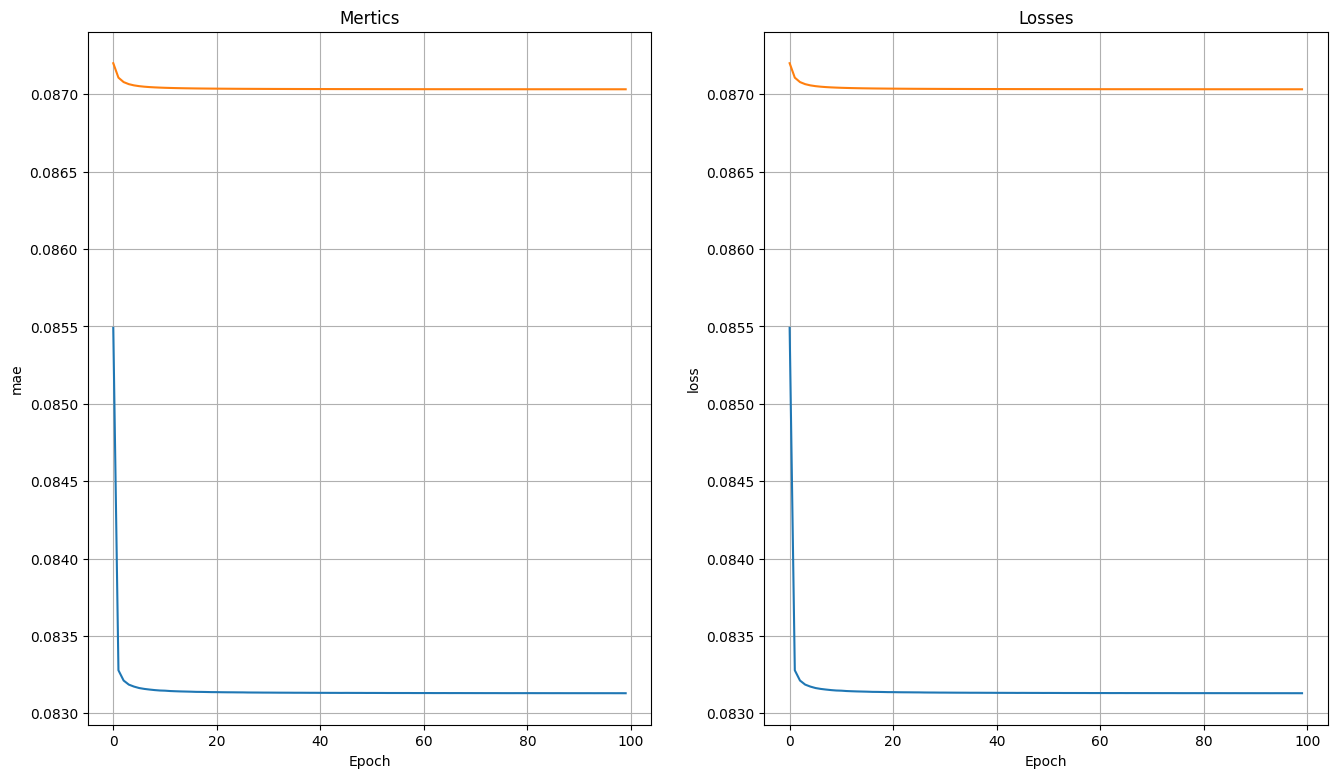

CPU times: user 7min 53s, sys: 31.1 s, total: 8min 24s
Wall time: 9min 29s


In [97]:
%%time
layers_grid = [[512, 256]]

nn_res = []

for layers in layers_grid:
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

    nn_model = get_nn(X_train.shape[1], layers, output_neurons=1, output_act='sigmoid')
    nn_model.compile(optimizer=optimizer, loss='mae', metrics='mae')

    history = nn_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                         epochs=100, verbose=1, callbacks=[stop])

    nn_prediction = nn_model.predict(X_valid)
    results = mean_absolute_error(nn_prediction.reshape(-1), \
                                torch.tensor(y_valid.values).type(torch.FloatTensor))
    print(f'Сеть {layers}, mae {results}')

    nn_res.append(['Dense with Dropout', layers, results])
    plt_result(history)

In [98]:
nn_res

[['Dense with Dropout', [512, 256], 0.08703243]]

In [99]:
df_results = pd.concat([df_results, pd.DataFrame(nn_res, columns=columns)]).reset_index(drop=True)

In [100]:
df_results

model   Parametrs   metrics
0               Ridge    alpha=10  0.141349
1  Dense with Dropout  [512, 256]  0.087032

Были проверены модели логистической регресси и полносвязная нейронная сеть.
Лучший результат показала модель полносвязной нейронной сети с двумя скрытыми слоями с 512 и 256 нейронами в этих слоях.

# Проверка на тестовых данных

In [101]:
# загрузим тестовые данные
datagen_test = ImageDataGenerator(rescale=1.0/255)

test_datagen_flow = datagen_test.flow_from_dataframe(
    dataframe = df_test,
    directory = os.path.join(DATA_PATH, 'test_images'),
    x_col='image',
    target_size=(224, 224),
    class_mode=None,
    batch_size=32,
    shuffle=True,
    seed=1
)

Found 500 validated image filenames.


In [102]:
# Преобразуем изображения
image_features_test = model_image.predict(test_datagen_flow)

16/16 [==============================] - 5s 263ms/step


In [103]:
df_test_image_features = pd.concat([df_test, pd.DataFrame(image_features_test)], axis=1)
df_test_image_features.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image    0    1    2    3         4    5    6  ...  \
0  1177994172_10d143cb8d.jpg  0.0  0.0  0.0  0.0  0.938549  0.0  0.0  ...   
1  1177994172_10d143cb8d.jpg  0.0  0.0  0.0  0.0  1.099204  0.0  0.0  ...   
2  1177994172_10d143cb8d.jpg  0.0  0.0  0.0  0.0  1.306000  0.0  0.0  ...   
3  1177994172_10d143cb8d.jpg  0.0  0.0  0.0  0.0  1.200138  0.0  0.0  ...   
4  1177994172_10d143cb8d.jpg  0.0  0.0  0.0  0.0  1.329910  0.0  0.0  ...   

   2038  2039  2040  2041      2042  2043  2044      2045  2046  2047  
0   0.0   0.0   0.0   0.0  0.000666   0.0   0.0  1.842734   0.0   0.0  
1   0.0   0.0   0.0   0.0  0.012424   0.0   0.0  2.220718   0.0   0.0  
2   0.0   0.0   0.0   0.0  0.024077   0.0   0.0  1.954245   0.0   0.0  
3   0.0   0.0   0.0   0.0  0.026777   0.0   0.0  1.810751   0.0   0.0  
4   0.0   0.0   0.0   0.0  0.022601   0.0   0.0  1.950501   0.0   0.0  

[5 rows x 2051 columns]

In [104]:
# создадим фукнцию, находящую наиболее похожее изображение
def testing(text):
    print(f'Описание: {text}')
    for word in text.split():
        if word in block_words:
            return 'Изображение попадает под юридические ограничения'
    Xids_test = vectorizer.transform([text]).toarray()
    best = 0
    best_index = 0
    pred_list = []

    for i in range(len(image_features_test)):

        X_test = pd.DataFrame(image_features_test[i]).T.merge(pd.DataFrame(Xids_test), left_index=True, \
                                                      right_index=True, suffixes=(None, '_t'))

        X_test.columns = X_test.columns.astype(str)
        y_pred_test = lr_model.predict(X_test)
        pred_list.append(y_pred_test[0])

        if y_pred_test > best:
            best = y_pred_test
            best_index = i

    print(f'Лучшая вероятность: {best}')
    print(f'Лучший индекс: {best_index}')
    print(f'Лучшее изображение:')
    img = mpimg.imread(os.path.join(DATA_PATH, 'test_images/') + df_test_image_features.image[best_index])
    imgplot = plt.imshow(img)
    plt.show()

In [105]:
# получим 10 случайных текстовых описаний
queries_for_test = df_test_image_features['query_text'].sample(10, random_state=1)#, ignore_index=True)
queries_for_test

304    Three riders wearing black jerseys jump their ...
340    A choir in red uniforms singing in front of a ...
47     A woman walks and a little boy walks to the si...
67       A group of people in a large yard toss a disc .
479    One person in a crowd of people , wearing a bl...
485    A little kid splashes around in the kiddie poo...
310    a boy in a blue top is jumping off some rocks ...
31     A man feeding a horse wearing a blue strapped ...
249              Two dogs playing together in the snow .
90                              A boy plays basketball .
Name: query_text, dtype: object

Описание: Three riders wearing black jerseys jump their BMX bikes into the air .
Лучшая вероятность: [0.1831489]
Лучший индекс: 209
Лучшее изображение:


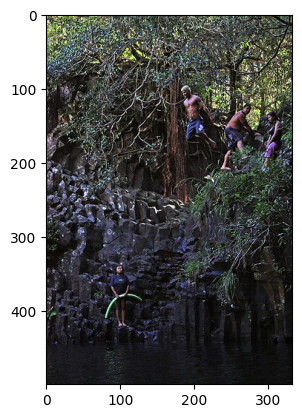

Описание: A choir in red uniforms singing in front of a business .
Лучшая вероятность: [0.13644323]
Лучший индекс: 209
Лучшее изображение:


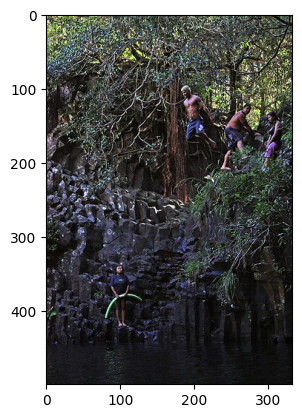

Описание: A woman walks and a little boy walks to the side of her .
Описание: A group of people in a large yard toss a disc .
Лучшая вероятность: [0.18926871]
Лучший индекс: 209
Лучшее изображение:


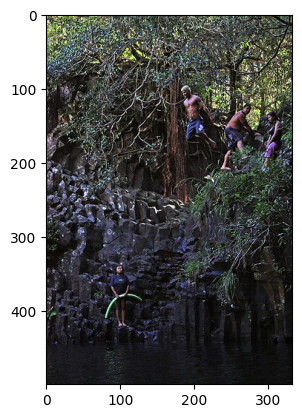

Описание: One person in a crowd of people , wearing a blue wig
Лучшая вероятность: [0.24994273]
Лучший индекс: 209
Лучшее изображение:


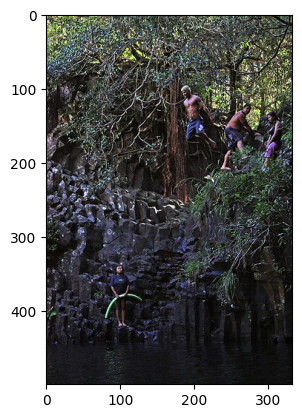

Описание: A little kid splashes around in the kiddie pool while a lady watches .
Описание: a boy in a blue top is jumping off some rocks in the woods .
Описание: A man feeding a horse wearing a blue strapped blanket .
Лучшая вероятность: [0.21139922]
Лучший индекс: 209
Лучшее изображение:


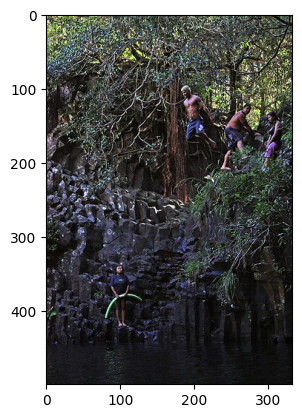

Описание: Two dogs playing together in the snow .
Лучшая вероятность: [0.21852851]
Лучший индекс: 209
Лучшее изображение:


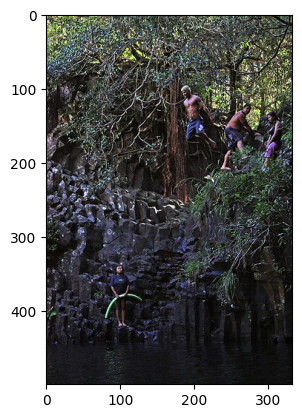

Описание: A boy plays basketball .


In [106]:
# применим функцию для этих описаний
for string in queries_for_test:
    testing(string)

In [107]:
# создадим фукнцию, находящую наиболее похожее изображение
def testing_nn(text):
    print(f'Описание: {text}')
    for word in text.split():
        if word in block_words:
            return 'Изображение попадает под юридические ограничения'
    Xids_test = vectorizer.transform([text]).toarray()
    best = 0
    best_index = 0
    pred_list = []

    for i in range(len(image_features_test)):

        X_test = pd.DataFrame(image_features_test[i]).T.merge(pd.DataFrame(Xids_test), left_index=True, \
                                                      right_index=True, suffixes=(None, '_t'))

        X_test.columns = X_test.columns.astype(str)
        y_pred_test = nn_model.predict(X_test)
        pred_list.append(y_pred_test[0])

        if y_pred_test > best:
            best = y_pred_test
            best_index = i

    print(f'Лучшая вероятность: {best}')
    print(f'Лучший индекс: {best_index}')
    print(f'Лучшее изображение:')
    img = mpimg.imread(os.path.join(DATA_PATH, 'test_images/') + df_test_image_features.image[best_index])
    imgplot = plt.imshow(img)
    plt.show()

Описание: Three riders wearing black jerseys jump their BMX bikes into the air .
1/1 [==============================] - 0s 25ms/step
Лучшая вероятность: [[3.79031e-06]]
Лучший индекс: 104
Лучшее изображение:


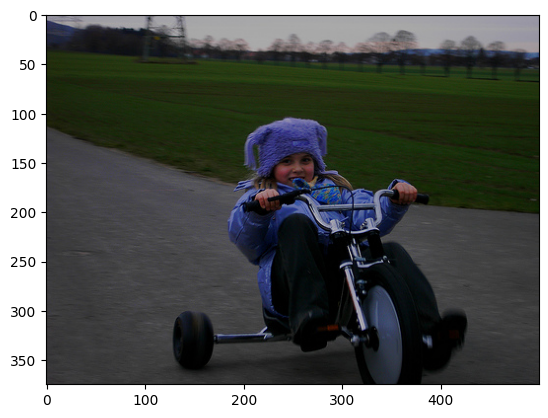

Описание: A choir in red uniforms singing in front of a business .
1/1 [==============================] - 0s 18ms/step
Лучшая вероятность: [[3.899131e-06]]
Лучший индекс: 104
Лучшее изображение:


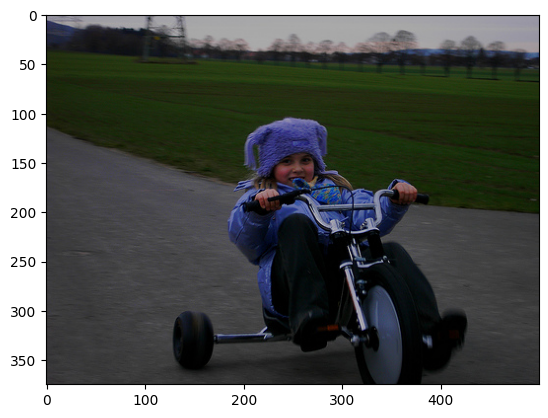

Описание: A woman walks and a little boy walks to the side of her .
Описание: A group of people in a large yard toss a disc .
1/1 [==============================] - 0s 40ms/step
Лучшая вероятность: [[3.6697522e-06]]
Лучший индекс: 104
Лучшее изображение:


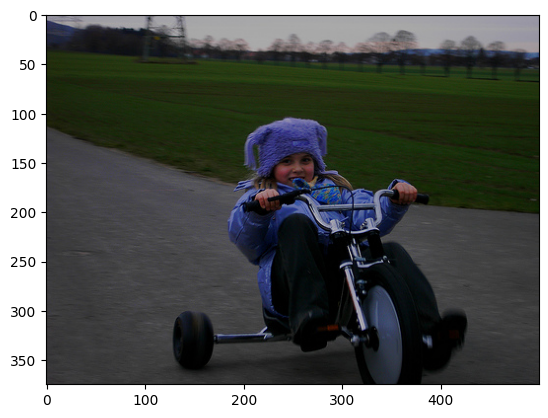

Описание: One person in a crowd of people , wearing a blue wig
1/1 [==============================] - 0s 27ms/step
Лучшая вероятность: [[3.7387533e-06]]
Лучший индекс: 104
Лучшее изображение:


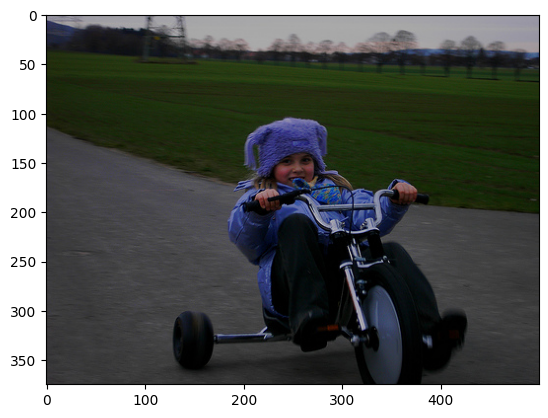

Описание: A little kid splashes around in the kiddie pool while a lady watches .
Описание: a boy in a blue top is jumping off some rocks in the woods .
Описание: A man feeding a horse wearing a blue strapped blanket .
1/1 [==============================] - 0s 20ms/step
Лучшая вероятность: [[3.7626112e-06]]
Лучший индекс: 104
Лучшее изображение:


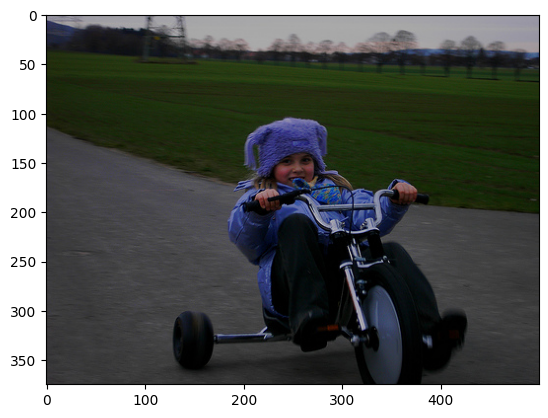

Описание: Two dogs playing together in the snow .
1/1 [==============================] - 0s 17ms/step
Лучшая вероятность: [[3.5833102e-06]]
Лучший индекс: 104
Лучшее изображение:


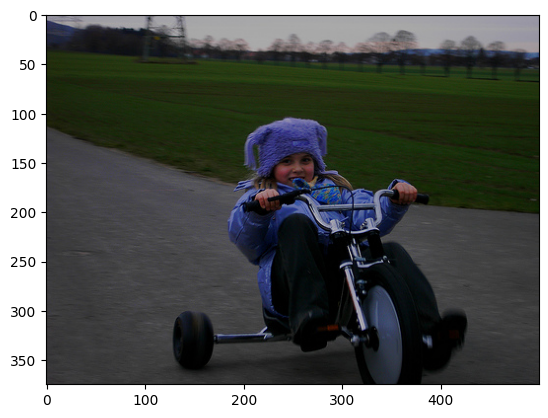

Описание: A boy plays basketball .


In [108]:
# применим функцию для этих описаний
for string in queries_for_test:
    testing_nn(string)

# Выводы:
В ходе проекта:
- выполнен исследовательский анализ полученных данных,
- исключены описания и изображения, попадающие под ограничения,
- изображения и текстовые описания были преобразованы в вектора,
- обучены модели логистической регрессии и полносвязной нейронной сети,
- проверена работа модели, а именной для 10 случайных изображений были получены наиболее подходящие (по версии модели) изображения.